En esta sesión vamos a aprender a resolver problemas de segmentación semántica y veremos la principal arquitectura para realizar segmentación de isntancias.

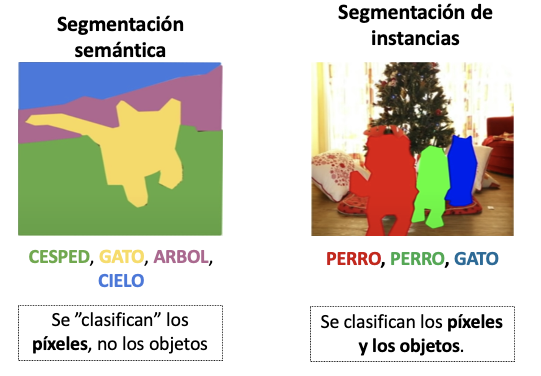

# Segmentación semántica

En segmentación semántica podemos encontrar dos tipos principales:
- **Binaria**: solo se quiere segmentar un objeto. Por lo tanto, la máscara estará formada por una matriz con 1s y 0s, donde los píxeles a 1 corresponden con los píxeles que forman el objeto de interés.
- **Multiclase**: se quiere segmentar más de un objeto. La máscara estará formada por una matriz con tantos números como clases a segmentar.

## Segmentación semántica multiclase

Para afrontar este problema vamos a hacer uso de un subconjunto de imágenes de la base de datos del simulador CARLA, empleada para el entrenamiento de modelos de conducción autónoma. 

Se trata de un subconjunto de las imágenes que podemos encontrar en el [reto de Kaggle](https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge).

Vamos a emplear un conjunto de 1000 imágenes en las que tenemos la imagen real y su correspondiente segmentación en 13 clases.

- 0: Fondo
- 1: Edificios
- 2: Vallas
- 3: Otro
- 4: Peatones
- 5: Postes
- 6: Líneas de carretera
- 7: Calles
- 8: Acera
- 9: Vegetación
- 10: Vehículos
- 11: Paredes
- 12: Señales de tráfico


In [1]:
# Dependencias tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

# Dependencia para trabajar con archivos ZIP
import zipfile

# Otras liberías
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import pandas as pd
import seaborn as sns

Google Collab

In [2]:
# Descargamos la base de datos

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Nos autenticamos con nuestra cuenta de Google Drive para acceder a los datos
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Nos descargamos las imagenes que vamos a emplear
download = drive.CreateFile({'id': '1jDZKheccRrAnLmWC7sWpdgbEji6yezwW'})
download.GetContentFile('dataset_segmentation.zip')

In [3]:
# Descomprimimos la base de datos descargada
with zipfile.ZipFile('dataset_segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset_segmentation')

In [ ]:
# Poned a False la siguente variable si no queréis conectar el notebook con vuestro Google Drive
connect_to_google_drive = False

if connect_to_google_drive:
    from google.colab import drive

    drive.mount('/content/drive')

    # Adaptad a la carpeta que queráis de Google Drive
    root_path = Path('drive/My Drive/mislata_ia_imagenes/')
else:
    root_path = Path.cwd()

Mounted at /content/drive


Local path

In [ ]:
root_path = Path.cwd()

### 1. Creación Datasets

El método "image_dataset_from_directory", que hemos visto anteriormente para crear los "Dataset", es muy específico para la resolución de problemas de clasificación. 

Para un problema de segmentación debemos de crear nosotros mismos los datasets, de manera que contengan tanto las imágenes como las máscaras.

En primer lugar implementamos un método que dados los directorio de una imagen y su máscara correspondiente, me devuelva un tensor con dicha imagen y la máscara correspondiente.

La máscara, como hemos visto anteriormente, deberá estar codificada en OneHot, es decir, deberemos de tener una matriz con tantos canales como etiquetas a segmentar (13 en este caso).

In [4]:
mask = tf.io.read_file('/content/dataset_segmentation/dataset_segmentation/CameraSeg/train/F61-100.png')

In [6]:
mask = tf.image.decode_png(mask, channels=3)

In [14]:
print(mask.shape)
mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
print(mask.shape)

(600, 800, 3)
(600, 800, 1)


In [15]:
mask = tf.squeeze(mask, axis=-1)

In [16]:
mask.shape

TensorShape([600, 800])

In [17]:
mask = tf.one_hot(tf.cast(mask, tf.int32), 13)
print(mask.shape)

(600, 800, 13)


In [ ]:
N_ROWS = 256
N_COLS = 256
N_LABELS = 13


def read_image(image_path, mask_path):
    # Leemos la imagen del directorio
    image = tf.io.read_file(image_path)
    # Decodificamos la imagen en función del tipo de codificación (PNG) en nuestro caso
    image = tf.image.decode_png(image, channels=3)
    # Convertimos la imagen a float32 --> Este método al mismo tiempo, al especificarle tipo de dato float hace el escalado a [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Redimensionamos la imagen al tamaño deseado
    image = tf.image.resize(image, (N_ROWS, N_COLS), method='nearest')

    # Leemos la máscara del directorio
    mask = tf.io.read_file(mask_path)
    # Decodificamos la imagen en función del tipo de codificación (PNG) en nuestro caso
    mask = tf.image.decode_png(mask, channels=3)
    # Las máscaras están guardadas de manera que el número de la etiqueta (0-12) se encuentra en el primer canal
    # Por lo tanto, nos quedamos con el valor máximo de cada canal para crear una matriz de tamaño [FILAS, COLUMNAS, 1]
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    # Redimensionamos la imagen al tamaño deseado
    mask = tf.image.resize(mask, (N_ROWS, N_COLS), method='nearest')
    # Eliminamos el último canal para quedarnos con matriz [FILAS, COLUMNAS]
    mask = tf.squeeze(mask, axis=-1)
    # Codificamos matriz a OneHot
    mask = tf.one_hot(tf.cast(mask, tf.int32), N_LABELS)

    return image, mask

Ahora, vamos a definir un método que, dada una lista de directorios de imágenes y máscaras correspondientes, nos genere el Dataset.

In [ ]:
def dataset_generator(image_paths, mask_paths, buffer_size, batch_size):
    image_list = tf.constant(image_paths)
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    # A cada elemento del dataset (directorios imagenes y máscaras) les aplicamos el método read_image
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)

    return dataset

Generamos lista con los directorios de las imágenes de entrenamiento, validación y test.

In [ ]:
img_dir_train = '/content/dataset_segmentation/dataset_segmentation/CameraRGB/train'
mask_dir_train = '/content/dataset_segmentation/dataset_segmentation/CameraSeg/train'
train_image_paths = glob.glob(os.path.join(img_dir_train, '*.png'))
train_mask_paths = glob.glob(os.path.join(mask_dir_train, '*.png'))

img_dir_val = '/content/dataset_segmentation/dataset_segmentation/CameraRGB/val'
mask_dir_val = '/content/dataset_segmentation/dataset_segmentation/CameraSeg/val'
val_image_paths = glob.glob(os.path.join(img_dir_val, '*.png'))
val_mask_paths = glob.glob(os.path.join(mask_dir_val, '*.png'))

img_dir_test = '/content/dataset_segmentation/dataset_segmentation/CameraRGB/test'
mask_dir_test = '/content/dataset_segmentation/dataset_segmentation/CameraSeg/test'
test_image_paths = glob.glob(os.path.join(img_dir_test, '*.png'))
test_mask_paths = glob.glob(os.path.join(mask_dir_test, '*.png'))

print('Número de imágenes de entrenamiento: ', len(train_image_paths))
print('Número de imágenes de validación: ', len(val_image_paths))
print('Número de imágenes de test: ', len(test_image_paths))


Número de imágenes de entrenamiento:  800
Número de imágenes de validación:  100
Número de imágenes de test:  100


Creamos datasets entrenamiento, validación y test.

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 500

train_dataset = dataset_generator(train_image_paths, train_mask_paths, BUFFER_SIZE, BATCH_SIZE)
validation_dataset = dataset_generator(val_image_paths, val_mask_paths, BUFFER_SIZE, BATCH_SIZE)
test_dataset = dataset_generator(test_image_paths, test_mask_paths, BUFFER_SIZE, BATCH_SIZE)

In [ ]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 13), dtype=tf.float32, name=None))>

Ya tenemos los Dataset listos, ahora vamos a visualizar algunos ejemplos para comprobar que la lectura y procesamiento se ha realizado correctamente.

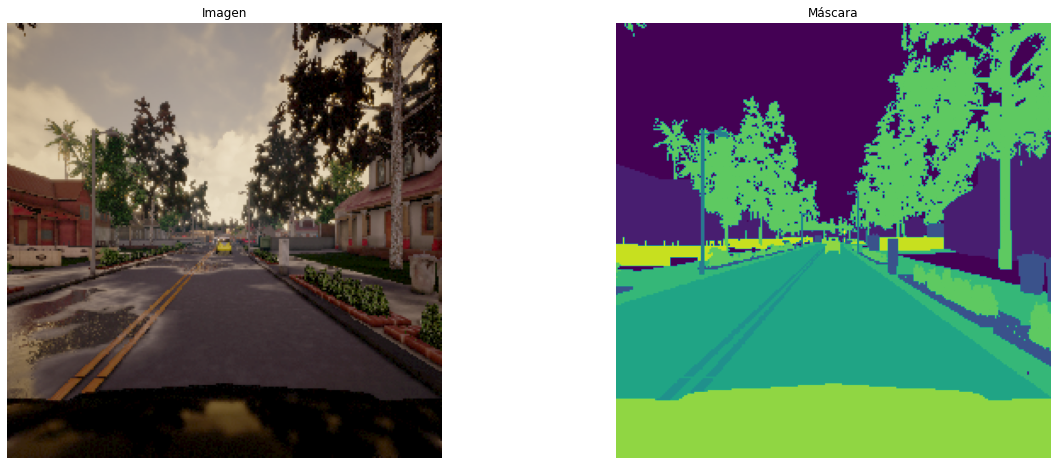

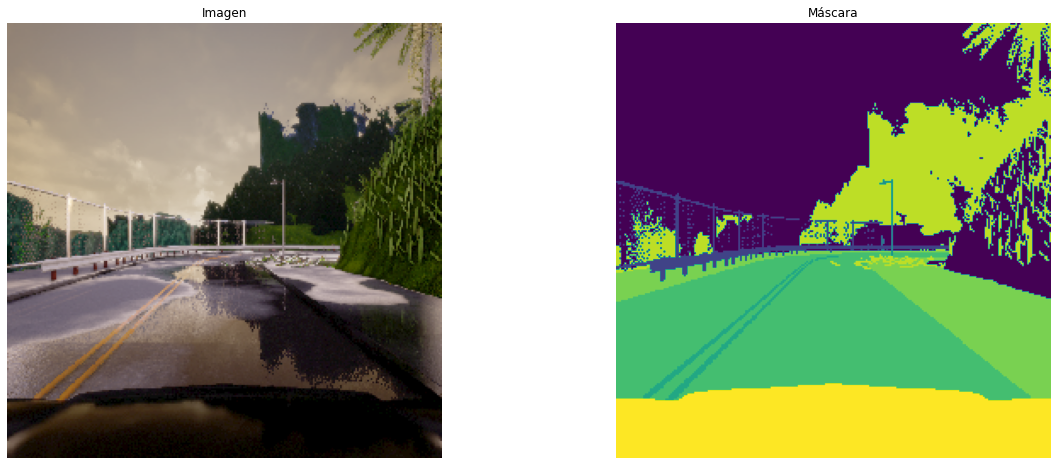

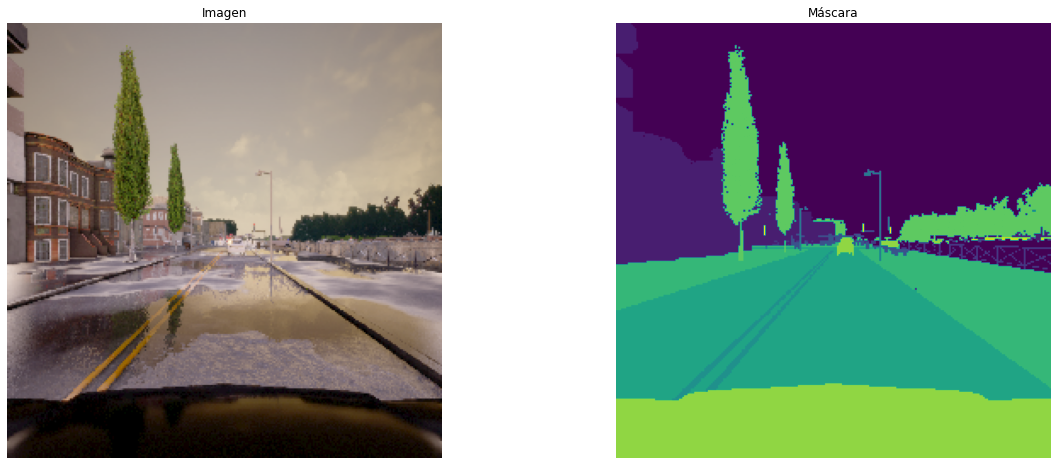

In [ ]:
for images, masks in train_dataset.take(1):
    for i in range(3):
        image, mask = images[i], masks[i]
        plt.figure(figsize=(20, 8))
        plt.subplot(121)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Imagen')
        plt.subplot(122)
        plt.imshow(np.argmax(mask, axis=-1))
        plt.axis('off')
        plt.title('Máscara')
        plt.show()

### 2. Definición de la arquitectura

Como arquitectura vamos a empelar la arquitectura UNET.

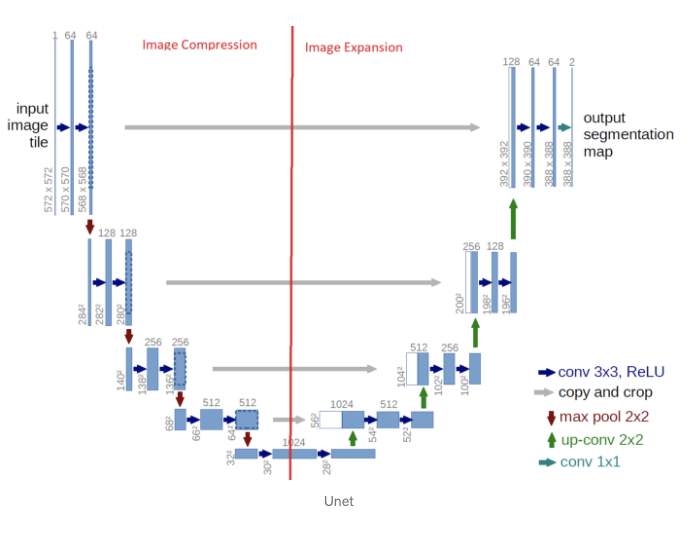

Al tratarse de un problema de segmentación multiclase vamos a emplear la función de activación **softmax**.

In [ ]:
IMAGE_SHAPE = (N_ROWS, N_COLS, 3)
ACTIVATION = 'softmax'


def get_unet():
    # Encoding phase
    inputs = layers.Input(IMAGE_SHAPE)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoding phase
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)

    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4],
                             axis=3)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3],
                             axis=3)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)

    out = layers.Conv2D(N_LABELS, (1, 1))(conv9)

    # Output
    output = layers.Activation(ACTIVATION)(out)

    # Compile model with inputs and outputs
    model = models.Model(inputs=[inputs], outputs=[output])

    return model


In [ ]:
model_unet = get_unet()

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

### 3. Entrenamiento y validación

En segmentación, la exactitud no es la métrica más apropiada ya que no tiene en cuenta el solapamiento entre la máscara predicha y la real.

Para evaluar dicho solapamiento es más conveniente emplear métricas como el coeficiente dice (DC) o la intersección sobre la unión (IoU)




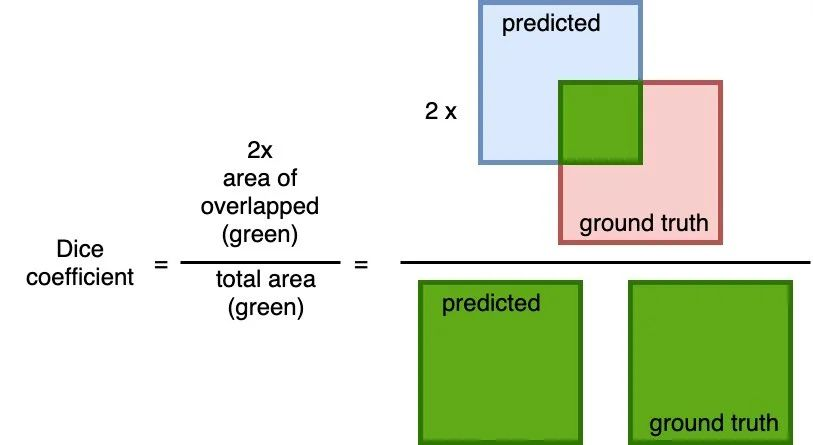

In [ ]:
# smooth para evitar dividir por 0
smooth = 1.


def dice_coef(targets, inputs):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    intersection = K.sum(targets * inputs)
    dice = (2 * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)

    return dice

En un problema multiclase, lo que haremos es calcular el coeficiente Dice medio a lo largo de todas las etiquetas.

In [ ]:
def dice_coef_multiclass(targets, inputs):
    sum_dice = 0
    for i in range(N_LABELS):
        sum_dice += dice_coef(targets[:, :, :, i], inputs[:, :, :, i])

    mean_dice = sum_dice / N_LABELS
    return mean_dice

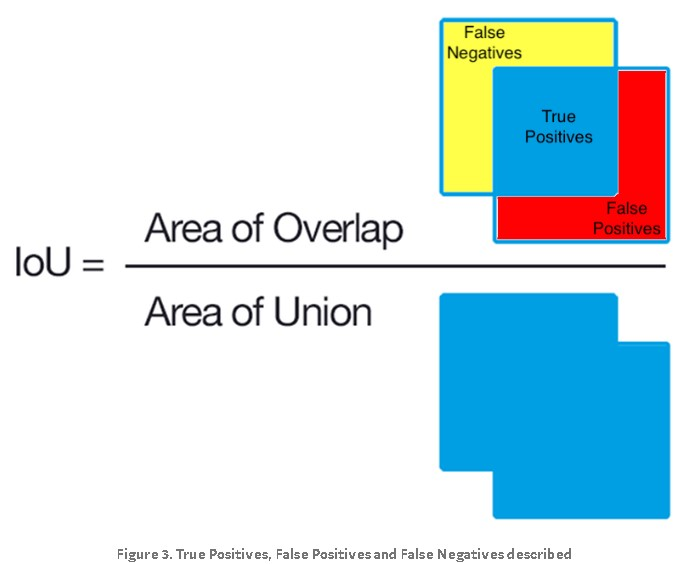

In [ ]:
def iou(targets, inputs):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    intersection = K.sum(targets * inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection

    IoU = (intersection + smooth) / (union + smooth)
    return IoU

En un problema multiclase, lo que haremos es calcular la intersección sobre la unión media a lo largo de todas las etiquetas.

In [ ]:
def iou_multiclass(targets, inputs):
    sum_iou = 0
    for i in range(N_LABELS):
        sum_iou += iou(targets[:, :, :, i], inputs[:, :, :, i])

    mean_iou = sum_iou / N_LABELS
    return mean_iou

Emplearemos la entropía cruzada categórica como función de pérdidas y extraeremos el coeficiente Dice y la intersección sobre la unión junto con la exactitud como métricas.

In [ ]:
model_unet.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy', dice_coef_multiclass, iou_multiclass])

In [ ]:
path_models = root_path / 'segmentation_multiclass' / 'models'
path_experiment = path_models / 'Train1'
path_experiment.mkdir(exist_ok=True, parents=True)

In [ ]:
EPOCHS = 50

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_experiment / 'model.h5',
    monitor='val_dice_coef_multiclass',
    mode='max',
    save_best_only=True,
    verbose=1)

history_unet = model_unet.fit(train_dataset,
                              epochs=EPOCHS,
                              validation_data=validation_dataset,
                              callbacks=[model_checkpoint_callback],
                              verbose=1)

np.save(path_experiment / 'history.npy', history_unet.history)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.5235 - accuracy: 0.6431 - dice_coef_multiclass: 0.1638 - iou_multiclass: 0.1076
Epoch 1: val_dice_coef_multiclass improved from -inf to 0.06148, saving model to drive/My Drive/mislata_ia_imagenes/segmentation_multiclass/models/Train1/model.h5
25/25 [==============================] - 64s 1s/step - loss: 1.5235 - accuracy: 0.6431 - dice_coef_multiclass: 0.1638 - iou_multiclass: 0.1076 - val_loss: 2.3800 - val_accuracy: 0.3132 - val_dice_coef_multiclass: 0.0615 - val_iou_multiclass: 0.0344
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.7621 - accuracy: 0.8493 - dice_coef_multiclass: 0.2812 - iou_multiclass: 0.2116
Epoch 2: val_dice_coef_multiclass improved from 0.06148 to 0.07327, saving model to drive/My Drive/mislata_ia_imagenes/segmentation_multiclass/models/Train1/model.h5
25/25 [==============================] - 19s 773ms/step - loss: 0.7621 - accuracy: 0.8493 - dice_coef_multiclass: 0.2812 -

In [ ]:
# Representamos la exactitud, coeficiente DICE e IOU en entrenamiento y validación
def show_learning_curves(history):
    plt.figure(figsize=(20, 5))
    # Exactitud
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.title('Exactitud')
    plt.ylim([0, 1])
    plt.legend()

    # Coeficiente DICE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['dice_coef_multiclass'], label='Entrenamiento')
    plt.plot(history.history['val_dice_coef_multiclass'], label='Validación')
    plt.xlabel('Época')
    plt.ylabel('DC')
    plt.title('Coeficiente Dice')
    plt.ylim([0, 1])
    plt.legend()

    # Intersección sobre la unión
    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou_multiclass'], label='Entrenamiento')
    plt.plot(history.history['val_iou_multiclass'], label='Validación')
    plt.xlabel('Época')
    plt.ylabel('IOU')
    plt.title('Intersección sobre la unión')
    plt.ylim([0, 1])
    plt.legend()

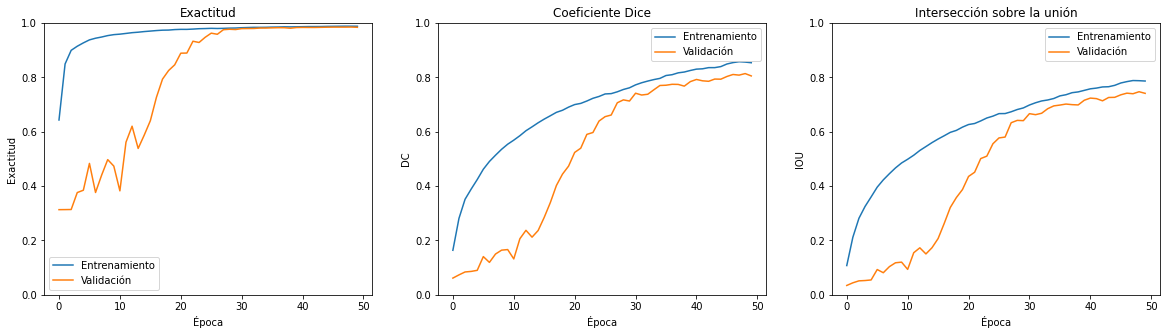

In [ ]:
show_learning_curves(history_unet)

### 4. Test

Finalmente, vamos a evaluar el rendimiento del modelo entrenado sobre el conjunto de datos de test.

En primer lugar, vamos a visualizar la segmentación predicha por el modelo y su comparativa con las máscaras de referencia en algunos casos del conjunto de datos de test.

In [ ]:
label_names = ['Fondo', 'Edificios', 'Vallas', 'Otro', 'Peatones', 'Postes', 'Lineas', 'Calles', 'Aceras', 'Vegetación',
               'Vehículos', 'Paredes', 'Señales']

In [ ]:
# Observamos visualmente la predicciones comparadas con las segmentaciones de referencia en algunas imágenes del set de test
def show_prediction(model):
    for images, masks in test_dataset.take(1):

        pred_masks = model.predict(images)
        for i in range(3):

            image, mask = images[i], masks[i]
            pred_mask = pred_masks[i]

            plt.figure(figsize=(20, 10))
            plt.subplot(131)
            plt.imshow(image)
            plt.axis('off')
            plt.title('Imagen')
            plt.subplot(132)
            plt.imshow(np.argmax(mask, axis=-1))
            plt.axis('off')
            plt.title('Máscara real')
            plt.subplot(133)
            plt.imshow(np.argmax(pred_mask, axis=-1))
            plt.axis('off')
            plt.title('Máscara predicha')
            plt.show()

            real_labels = np.unique(np.argmax(mask, axis=-1))
            predicted_labels = np.unique(np.argmax(pred_mask, axis=-1))
            print('Etiquetas máscara real: ', real_labels)
            print('Etiquetas máscara predicha: ', predicted_labels)
            for real_label in real_labels:
                if real_label not in predicted_labels:
                    print(f'Clase {label_names[real_label]} ({real_label}) no segmentada.')


In [ ]:
path_experiment = path_models / 'Train1'
model_unet = tf.keras.models.load_model(path_experiment / 'model.h5',
                                        custom_objects={"dice_coef_multiclass": dice_coef_multiclass,
                                                        "iou_multiclass": iou_multiclass})

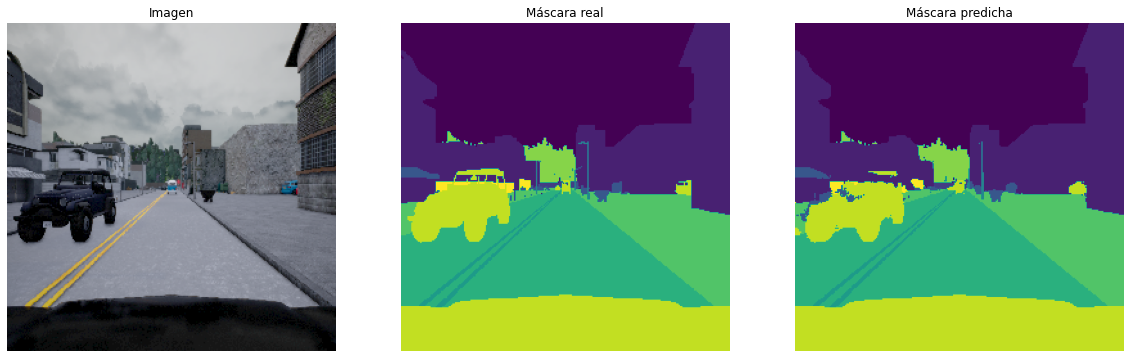

Etiquetas máscara real:  [ 0  1  2  3  5  6  7  8  9 10 11]
Etiquetas máscara predicha:  [ 0  1  2  3  5  6  7  8  9 10 11]


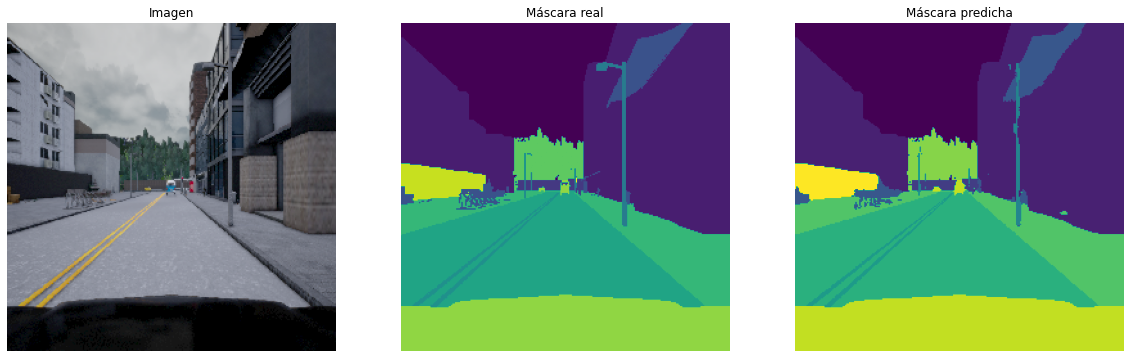

Etiquetas máscara real:  [ 0  1  2  3  5  6  7  8  9 10 11 12]
Etiquetas máscara predicha:  [ 0  1  2  3  5  6  7  8  9 10 11]
Clase Señales (12) no segmentada.


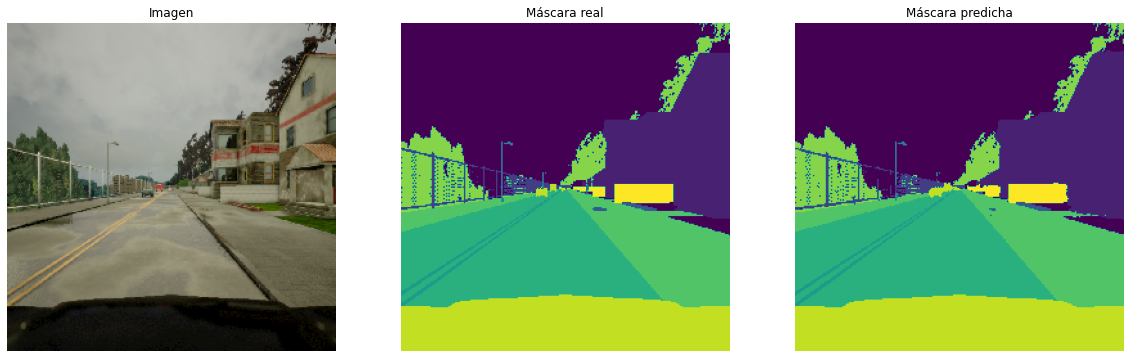

Etiquetas máscara real:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Etiquetas máscara predicha:  [ 0  1  2  3  5  6  7  8  9 10 11]
Clase Peatones (4) no segmentada.


In [ ]:
show_prediction(model_unet)

A continuación, vamos a extraer un conjunto de métricas para evaluar, de manera cuantitativa, el rendimiento del modelo entrenado. Para cada una de las clases vamos a calcular, imagen a imagen, las siguientes métricas:

* Coeficiente Dice
* Intersección sobre la unión (Coeficiente Jaccard)
* Precisión
* Sensibilidad (Recall)
* Especificidad

In [ ]:
# Coeficiente DICE
def dc(result, reference):
    result = result.astype(bool)
    reference = reference.astype(bool)

    intersection = np.count_nonzero(result & reference)

    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)

    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0

    return dc


# IOU == Coeficiente Jaccard
def intersection_over_union(result, reference):
    result = result.astype(bool)
    reference = reference.astype(bool)

    intersection = np.count_nonzero(result & reference)
    union = np.count_nonzero(result | reference)

    try:
        iou = float(intersection) / float(union)
    except ZeroDivisionError:
        iou = 0.0

    return iou


def precision(result, reference):
    result = result.astype(bool)
    reference = reference.astype(bool)

    tp = np.count_nonzero(result & reference)
    fp = np.count_nonzero(result & ~reference)

    try:
        precision = tp / float(tp + fp)
    except ZeroDivisionError:
        precision = 0.0

    return precision


def recall(result, reference):
    result = result.astype(bool)
    reference = reference.astype(bool)

    tp = np.count_nonzero(result & reference)
    fn = np.count_nonzero(~result & reference)

    try:
        recall = tp / float(tp + fn)
    except ZeroDivisionError:
        recall = 0.0

    return recall


def specificity(result, reference):
    result = result.astype(bool)
    reference = reference.astype(bool)

    tn = np.count_nonzero(~result & ~reference)
    fp = np.count_nonzero(result & ~reference)

    try:
        specificity = tn / float(tn + fp)
    except ZeroDivisionError:
        specificity = 0.0

    return specificity

In [ ]:
# Realizamos la predicción sobre el set de test
pred_masks = model_unet.predict(test_dataset)
print(pred_masks.shape)

(100, 256, 256, 13)


A la salida del modelo obtenemos, para cada canal, la probabilidad de que cada pixel pertenezca a la clase correspondiente a dicho canal. Por lo tanto, para definir la etiqueta asociada a cada pixel, seleccionamos aquella con mayor probabilidad.

In [ ]:
# La clase asociada a cada pixel es aquella en la que se ha obtenido la máxima probabilidad
pred_labels = np.argmax(pred_masks, axis=-1)

print(pred_labels.shape)

(100, 256, 256)


In [ ]:
# Extraemos las matrices de las máscaras de referencia del Dataset de test para calcular las métricas
test_labels = np.empty(shape=[0, 256, 256])
for _, masks in test_dataset.take(-1):  # cogemos todos los elementos del dataset
    labels = masks.numpy()
    labels = np.argmax(labels, axis=-1)
    test_labels = np.concatenate((test_labels, labels), axis=0)

print(test_labels.shape)

(100, 256, 256)


In [ ]:
n_images_test = len(pred_masks)

dc_test = np.zeros(shape=(n_images_test, N_LABELS))
iou_test = np.zeros(shape=(n_images_test, N_LABELS))
precision_test = np.zeros(shape=(n_images_test, N_LABELS))
recall_test = np.zeros(shape=(n_images_test, N_LABELS))
specificity_test = np.zeros(shape=(n_images_test, N_LABELS))

data = {'dc': [], 'iou': [], 'precision': [], 'recall': [], "specificity": [], "label": []}

# Para cada imagen y cada etiqueta calculamos las métricas definidas
for i in range(n_images_test):
    for j in range(N_LABELS):
        pred_binary = np.zeros(shape=(N_ROWS, N_COLS))
        pred_binary[pred_labels[i, :, :] == j] = 1

        real_binary = np.zeros(shape=(N_ROWS, N_COLS))
        real_binary[test_labels[i, :, :] == j] = 1

        dc_test[i, j] = dc(pred_binary, real_binary)
        iou_test[i, j] = intersection_over_union(pred_binary, real_binary)
        precision_test[i, j] = precision(pred_binary, real_binary)
        recall_test[i, j] = recall(pred_binary, real_binary)
        specificity_test[i, j] = specificity(pred_binary, real_binary)

        data['dc'].append(dc_test[i, j])
        data['iou'].append(iou_test[i, j])
        data['precision'].append(precision_test[i, j])
        data['recall'].append(recall_test[i, j])
        data['specificity'].append(specificity_test[i, j])
        data['label'].append(label_names[j])


In [ ]:
df = pd.DataFrame(data=data)

In [ ]:
df

,dc,iou,precision,recall,specificity,label
0,0.814422,0.686940,0.689964,0.993661,0.827018,Fondo
1,0.272988,0.158070,0.670988,0.171351,0.978015,Edificios
2,0.054920,0.028235,0.049793,0.061224,0.996495,Vallas
3,0.184681,0.101735,0.181435,0.188047,0.991025,Otro
4,0.000000,0.000000,0.000000,0.000000,0.999985,Peatones
...,...,...,...,...,...,...
1295,0.750959,0.601228,0.782582,0.721792,0.982389,Aceras
1296,0.188479,0.104045,0.138108,0.296686,0.883069,Vegetación
1297,0.924284,0.859226,0.859226,1.000000,0.970443,Vehículos
1298,0.013256,0.006672,0.023669,0.009206,0.994897,Paredes


Text(0.5, 1.0, 'Coeficiente Dice')

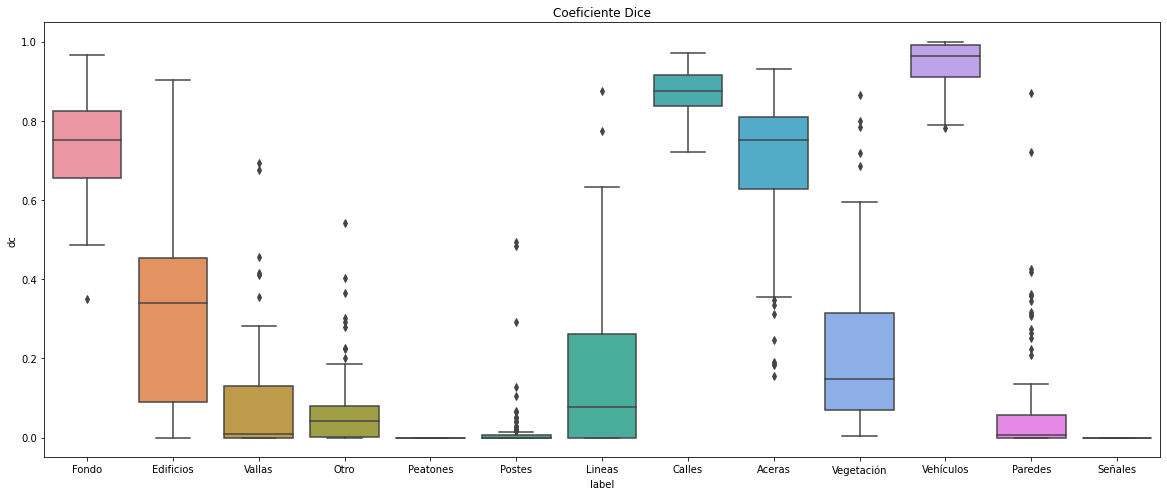

In [ ]:
plt.figure(figsize=(20, 8))
sns.boxplot(y='dc', x='label', data=df)
plt.title('Coeficiente Dice')

Text(0.5, 1.0, 'Intersección sobre la unión')

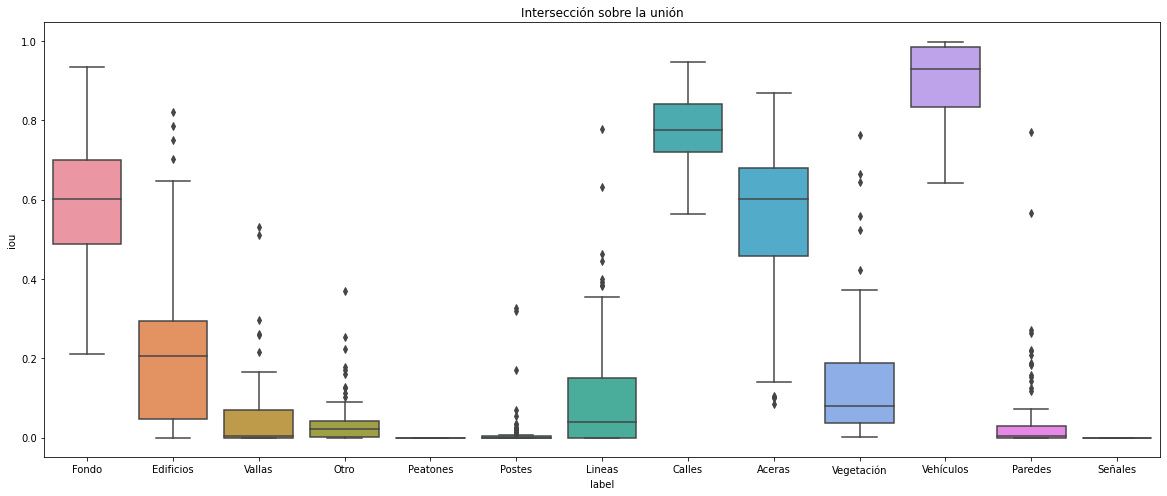

In [ ]:
plt.figure(figsize=(20, 8))
sns.boxplot(y='iou', x='label', data=df)
plt.title('Intersección sobre la unión')

Text(0.5, 1.0, 'Precision')

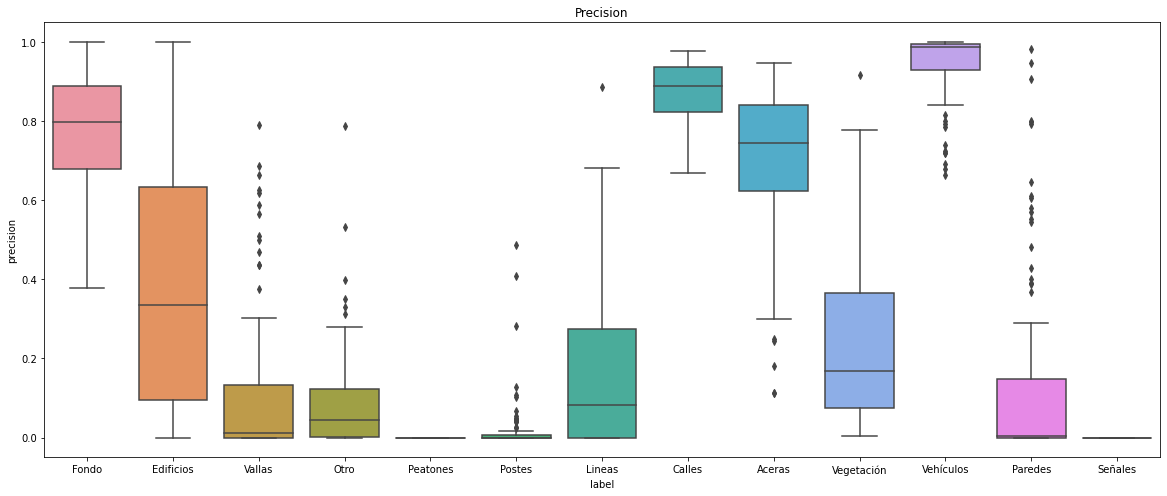

In [ ]:
plt.figure(figsize=(20, 8))
sns.boxplot(y='precision', x='label', data=df)
plt.title('Precision')

Text(0.5, 1.0, 'Sensibilidad')

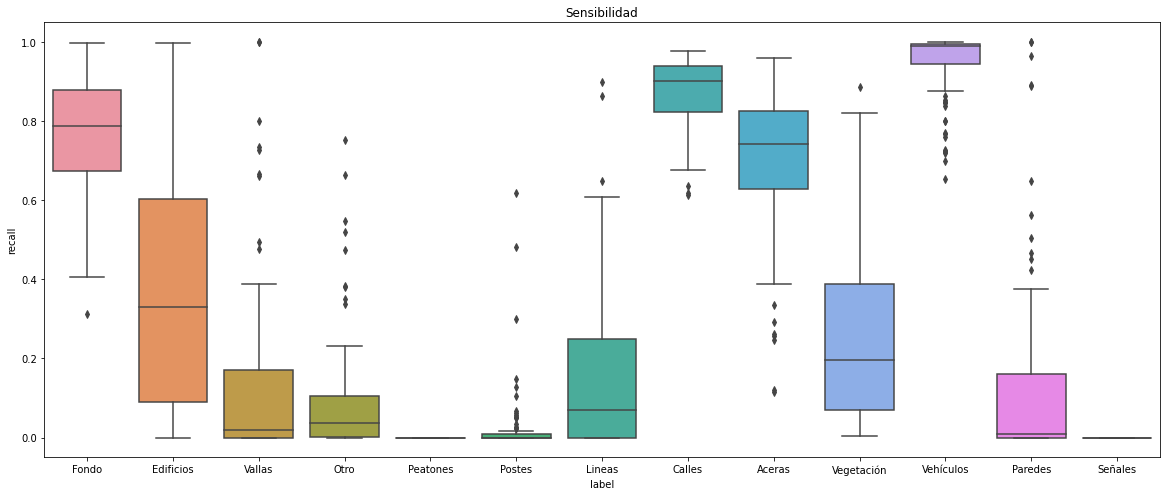

In [ ]:
plt.figure(figsize=(20, 8))
sns.boxplot(y='recall', x='label', data=df)
plt.title('Sensibilidad')

Text(0.5, 1.0, 'Especificidad')

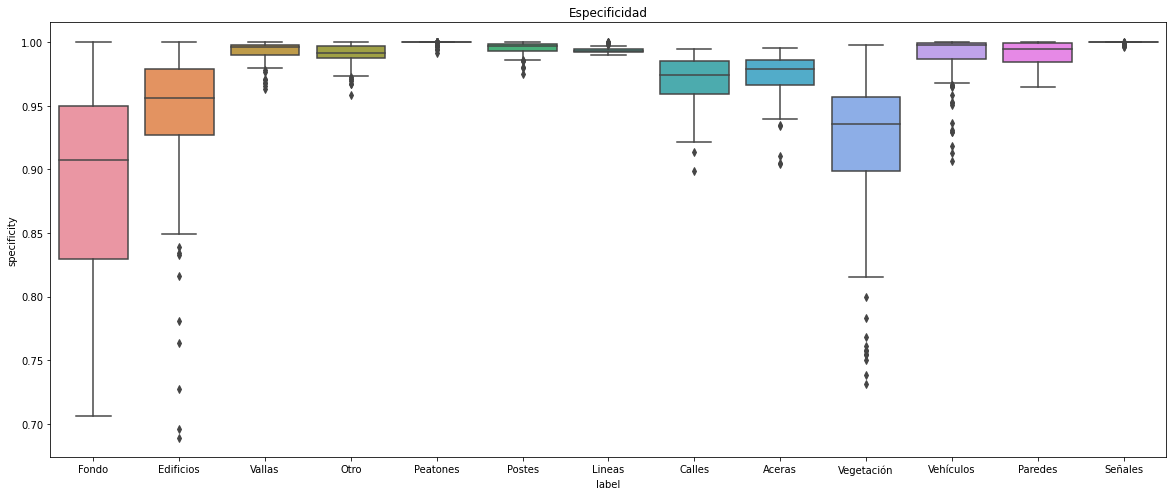

In [ ]:
plt.figure(figsize=(20, 8))
sns.boxplot(y='specificity', x='label', data=df)
plt.title('Especificidad')

In [ ]:
# Calculamos el valor medio de entre todas las imágenes de test de las métricas para cada etiqueta
for j in range(N_LABELS):
    print('Méticas clase ', label_names[j])

    print('Coeficiente DICE: ', np.mean(dc_test[:, j]))
    print('IOU: ', np.mean(iou_test[:, j]))
    print('Precisión: ', np.mean(precision_test[:, j]))
    print('Sensibilidad: ', np.mean(recall_test[:, j]))
    print('Especificidad: ', np.mean(specificity_test[:, j]))
    print('\n')

Méticas clase  Fondo
Coeficiente DICE:  0.7445481226378977
IOU:  0.6076527262725329
Precisión:  0.7627716760160692
Sensibilidad:  0.7599752607615762
Especificidad:  0.8885983049241196


Méticas clase  Edificios
Coeficiente DICE:  0.3279693780147119
IOU:  0.22261665810914333
Precisión:  0.370771687743495
Sensibilidad:  0.3681171901073364
Especificidad:  0.9384466727790515


Méticas clase  Vallas
Coeficiente DICE:  0.07989052419714532
IOU:  0.047797723274734055
Precisión:  0.11768148041283091
Sensibilidad:  0.12790823746694033
Especificidad:  0.9930429896136955


Méticas clase  Otro
Coeficiente DICE:  0.06609596826556548
IOU:  0.03699537140405901
Precisión:  0.08559762194219347
Sensibilidad:  0.09229690504452316
Especificidad:  0.9900765618077159


Méticas clase  Peatones
Coeficiente DICE:  0.0
IOU:  0.0
Precisión:  0.0
Sensibilidad:  0.0
Especificidad:  0.9996816432310027


Méticas clase  Postes
Coeficiente DICE:  0.020722173205538076
IOU:  0.012314248131124902
Precisión:  0.02121728619

Podemos observar que en regiones pequeñas, de momento, el modelo no funciona correctamente.

## Segmentación semántica binaria

### Ejercicio 1

En este ejercicio vais a adaptar el proceso anterior para resolver un problema de segmentación binaria. 

Para ello vais a hacer uso de una base de datos que contiene imágenes donde se ha segmentado la mascarilla qe llevan las personas que aparecen en estas. Decarga la base de datos con el siguente ID: 1lHTCGy8N45cr2aMcwBvTU5AI4SKljSsh y que tiene el nombre "mascarillas.zip".
También la podéis descargar del s

Una vez descargada la base de datos adapta el código de forma que:
- Adapta el método "read_image" de forma que, para la máscara, se cree una matriz de tamaño [N_FILAS, N_COLUMNAS, 1], donde los píxeles con mascarilla estén a 1. En este caso las imágenes PNG pertenecientes a la mascarilla son imágenes en RGB donde la máscara tiene un valor (255, 255, 255). 
- Se van a crear solo dos datasets: entrenamiento y validación. Para no reducir más el tamaño de la base de datos de entrenamiento emplearemos como test también el de validación.
- Adapta la arquitectura para responder a un problema de segmentación binaria.
- Compila el modelo haciendo uso de los métodos adecuados para la función de coste y las métricas.
- Entrena durante 50 épocas.